install libraries

In [46]:
import whisper
import os

from evaluate import load
import audiosegment

d:\ChatterChop\.venv\lib\site-packages\whisper\timing.py:58: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def backtrace(trace: np.ndarray):
d:\ChatterChop\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model = whisper.load_model("small")
audio = whisper.load_audio(ASRPage.output_file_path)
result = model.transcribe(audio)

audio transcription

In [2]:
def transcription(path_to_audio_file, path_to_transcription_file, model_name='small', language='pl'):

    model = whisper.load_model(model_name)
    result = model.transcribe(path_to_audio_file, language=language)

    with open(path_to_transcription_file, "a", encoding="utf-8") as file_txt:
        file_txt.write(f"{result['text']}\n")

test transcription

In [8]:
audio_relative_path = os.path.join("..", "test_data", "test_audio_pl.wav")
transcription_relative_path = os.path.join("..", "test_data", "test_transcription.txt")

In [ ]:
transcription(audio_relative_path, transcription_relative_path)

Transcription metrics

In [6]:
ground_truth = os.path.join("..", "test_data", "test_transcription_ground_truth.txt")
transcription_to_test = os.path.join("..", "test_data", "test_transcription.txt")

In [43]:
def txt_into_list(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            text = text.strip()
            text = ''.join(char.lower() if char.isalnum() or char.isspace() else ' ' for char in text)
            one_long_sentence = ' '.join(text.split())
            sentence_list = [one_long_sentence]
            return sentence_list
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return []

In [44]:
list_transcription_to_test = txt_into_list(transcription_to_test)
list_ground_truth = txt_into_list(ground_truth)

In [45]:
print(list_transcription_to_test)
print(list_ground_truth)

['warszawa jest miastem pełnym sprzeczności przez wielu nazywanym niezniszczalnym miasto to wzbudza zachwyt prowokuje i inspiruje panującą w nim atmosferę o magicznym duchu nieistniejących już miejsc tworząc unikalne zestawienie zabytkowych budynków z nowoczesną miejską architekturą a przykładem niezwykłej niezłomności stolicy jest jej stare miasto warszawa jest miastem pełnym sprzeczności przez wielu nazywanym niezniszczalnym']
['warszawa jest miastem pełnym sprzeczności przez wielu nazywanym niezniszczalnym miasto to wzbudza zachwyt prowokuje i inspiruje panującą w nim atmosferą o magicznym duchu nieistniejących już miejsc tworząc unikalne zestawienie zabytkowych budynków z nowoczesną miejską architekturą a przykładem niezwykłej niezłomności stolicy jest jej stare miasto warszawa jest miastem pełnym sprzeczności przez wielu nazywanym niezniszczalnym']


In [46]:
wer = load('wer')
wer_score = wer.compute(predictions=list_transcription_to_test, references=list_ground_truth)
print(wer_score)

0.018867924528301886


In [48]:
cer = load("cer")
cer_score = cer.compute(predictions=list_transcription_to_test, references=list_ground_truth)
print(cer_score)

0.002336448598130841


In [66]:
def write_words_to_file(sentence, output_file_path):
    try:
        if len(sentence) == 1:
            words = sentence[0].split()
            with open(output_file_path, 'w', encoding='utf-8') as output_file:
                for word in words:
                    output_file.write(word + '\n')
        else:
            print("Invalid input. The 'sentence' parameter should be a list containing one long string.")
    except Exception as e:
        print(f"Error writing to file: {str(e)}")

In [67]:
splitted_words = os.path.join("..", "test_data", "word_by_word.txt")
write_words_to_file(list_ground_truth, splitted_words)

Perform VAD and split the audio

In [4]:
def split_audio(audio_path, transcription):
    if not transcription:
        return

    audio = audiosegment.from_file(audio_path)
    word_segments = []

    for result in transcription.get("alternative", []):
        transcript = result.get("transcript", "")
        if transcript:
            for word_info in result.get("words", []):
                start_time = float(word_info.get("start", 0))
                end_time = float(word_info.get("end", 0))
                word_audio = audio[start_time * 1000:end_time * 1000]
                word_segments.append(word_audio)

    return word_segments

def vad(audio_path):
    audio = audiosegment.from_file(audio_path)
    speech_segments = []

    silence = audiosegment.empty()
    current_segment = []

    for segment in audio:
        if segment.dBFS > silence.dBFS:
            current_segment.append(segment)
        else:
            if current_segment:
                speech_segments.append(audiosegment.from_mono_audiosegments(*current_segment))
            current_segment = []

    return speech_segments

In [3]:
from pydub import AudioSegment
import speech_recognition as sr
import os

audio_path = os.path.join("..", "test_data", "test_audio_pl.wav")
audio = AudioSegment.from_file(audio_path)

# Initialize the speech recognition engine
recognizer = sr.Recognizer()

# Split the audio into segments based on speech detection
def split_audio_segments(audio):
    audio_duration = len(audio)
    start_time = 0
    end_time = 0
    segments = []

    while start_time < audio_duration:
        # Set the end time for the next segment
        end_time = start_time + 1000  # Adjust this value as needed

        if end_time > audio_duration:
            end_time = audio_duration

        # Extract the segment
        segment = audio[start_time:end_time]

        # Recognize speech in the segment
        with sr.AudioFile(segment.export(format="wav")) as source:
            audio_data = recognizer.record(source)
            try:
                # Use Google Web Speech API for speech recognition
                word = recognizer.recognize_google(audio_data)
                segments.append(word)
            except sr.UnknownValueError:
                pass

        # Move to the next segment
        start_time = end_time

    return segments

# Split the audio into word segments
word_segments = split_audio_segments(audio)

# Print the word segments
for idx, word in enumerate(word_segments):
    print(f"Word {idx + 1}: {word}")


Word 1: play some Justin
Word 2: news
Word 3: play insper
Word 4: who is Buddha Zack
Word 5: show me calendar
Word 6: no
Word 7: what's the weather music
Word 8: play SDA
Word 9: stop


In [ ]:
import librosa
import librosa.display
import numpy as np
import speech_recognition as sr
import soundfile as sf
import os
import tempfile


audio_path = os.path.join("..", "test_data", "test_audio_pl.wav")
output_path = os.path.join("..", "test_data", "test_split")
y, sr = librosa.load(audio_path, sr=None)

# Define frame parameters (adjust as needed)
frame_length = 512  # Length of each frame in samples
hop_length = 256     # Hop size (overlap) between frames in samples

# Calculate the short-term energy of each frame
frame_y = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)
energy = np.sum(np.abs(frame_y), axis=0)
for i, ener in enumerate(energy):
    print(ener)
# Set a threshold to distinguish between speech and silence
energy_threshold = 2.25  # Adjust as needed

# Initialize variables for word segmentation
word_segments = []
start_frame = None

# Iterate through frames and perform word segmentation
for frame_idx, frame_energy in enumerate(energy):
    if frame_energy > energy_threshold and start_frame is None:
        # Start of a word
        start_frame = frame_idx
        print(frame_energy)
    elif frame_energy <= energy_threshold and start_frame is not None:
        print(frame_energy)
        end_frame = frame_idx
        word_segments.append((start_frame, end_frame))
        start_frame = None

for segment_idx, (start_frame, end_frame) in enumerate(word_segments):
    start_sample = start_frame * hop_length
    end_sample = end_frame * hop_length
    word_audio = y[start_sample:end_sample]

    sf.write(f'{os.path.join(output_path, str(segment_idx))}.wav', word_audio, sr)

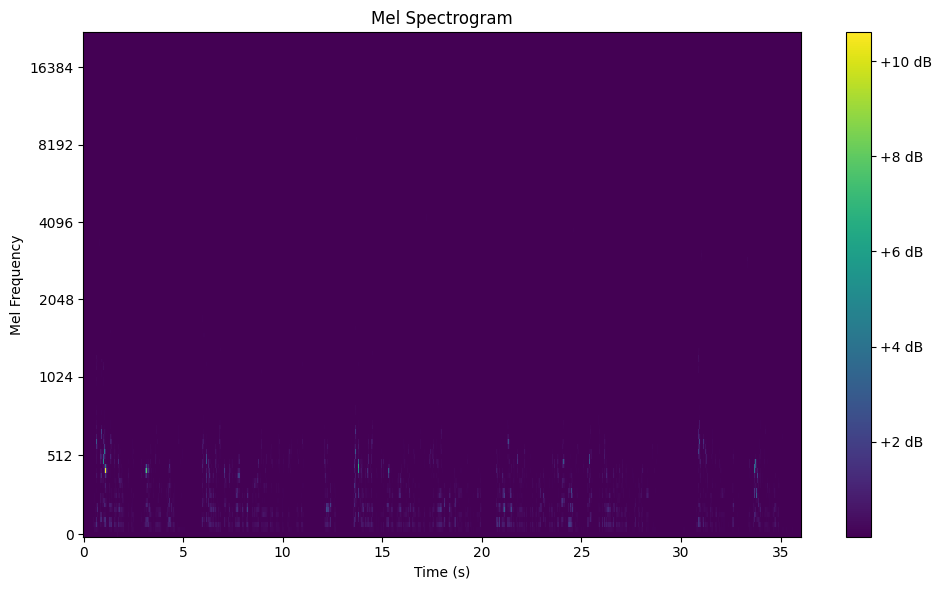

In [45]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

audio_path = os.path.join("..", "test_data", "test_audio_pl.wav")

y, sr = librosa.load(audio_path, sr=None)

# Create the Mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
# Plot the Mel spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=sr, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency')
plt.tight_layout()
plt.show()

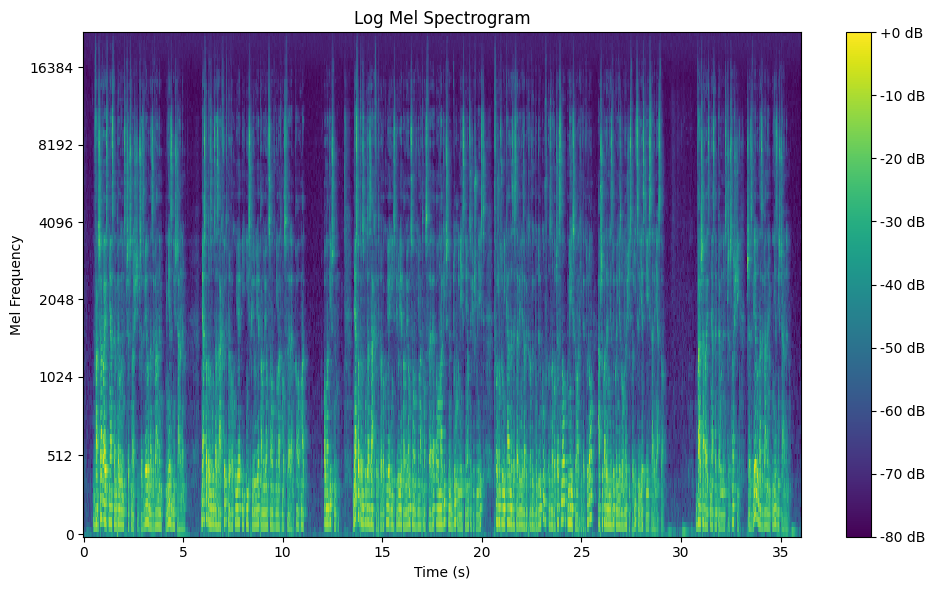

In [44]:
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Plot the log Mel spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', sr=sr, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Log Mel Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency')
plt.tight_layout()
plt.show()
